# A tensorflow model for Dictionary Filter

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

2024-07-11 22:24:07.155405: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 22:24:07.498167: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 22:24:08.217527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
sys.path.append('../Library')

from Metrics.NMSE import NMSE
from Modules.GaussianDictionaryFilter import GaussianDictionaryFilter as DictionaryFilter

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Test on the Full Netflix dataset

In [4]:
# Read the dataset
dataset = pd.read_csv('../Data/Netflix/Full/dataset.csv')

# Display the dataset
dataset.head()

,Movie Index,User Index,Rating
0,0,270045,3
1,0,149546,5
2,0,160878,4
3,0,5466,4
4,0,149791,3


In [5]:
from sklearn.model_selection import train_test_split
from AdvancedModelSelection import user_based_train_test_split

# Split the dataset into train and test data
train_val_data, test_data = user_based_train_test_split(dataset, test_size=0.2, random_state=42)

# Split the train and validation data
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (72345938, 3)
Validation data shape: (8038438, 3)
Test data shape: (20096131, 3)


In [6]:
NUM_MOVIES = dataset['Movie Index'].max() + 1
NUM_USERS = dataset['User Index'].max() + 1
NUM_FACTORS = 16
BATCH_SIZE = 128
TRAIN_LAMBDA = 2.0
INIT_SCALE = dataset['Rating'].mean() / NUM_FACTORS
NUM_EPOCHS = 20

In [7]:
# Convert train data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert validation data to sparse tensor
val_sparse_tensor = tf.sparse.SparseTensor(
    indices=val_data[['Movie Index', 'User Index']].values,
    values=val_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
val_sparse_tensor = tf.sparse.reorder(val_sparse_tensor)

# Convert test data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

2024-07-11 22:26:14.494413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-11 22:26:14.752073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-11 22:26:14.752131: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-11 22:26:14.776779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-11 22:26:14.776814: I external/local_xla/xla/stream_executor

In [8]:
# Create dataset
def create_train_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

def create_full_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        test_slices = tf.sparse.split(sp_input=test_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]), tf.sparse.to_dense(test_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

## Experiments
### 1. Batch size vs train time vs NMSE

In [9]:
# Initialize variables
batch_sizes = [8, 32, 128, 512]
nmse_train_results = np.zeros((len(batch_sizes), 5))
nmse_val_results = np.zeros((len(batch_sizes), 5))
train_timer = np.zeros((len(batch_sizes)))

for i, batch_size in enumerate(batch_sizes):

    # Create the model
    model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
    nmse_train = NMSE()
    nmse_val = NMSE()

    # Create the dataset
    dataset = create_train_dataset(batch_size)
        
    start_time = time.time()  # Start the timer

    # Train the model
    for epoch in range(5):
        progress_bar = tqdm(total=NUM_USERS // batch_size, desc=f"Epoch {epoch+1}", unit="batch")
        
        for train_batch, val_batch in dataset:
            x = model(train_batch)
            nmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            nmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
            progress_bar.update(1)
        
        progress_bar.close()

        print("Train NMSE:", nmse_train.result().numpy())
        print("Val NMSE:", nmse_val.result().numpy())
        nmse_train_results[i, epoch] = nmse_train.result().numpy()
        nmse_val_results[i, epoch] = nmse_val.result().numpy()

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    train_timer[i] = elapsed_time  # Store the elapsed time

Epoch 1: 100%|██████████| 60023/60023 [12:09<00:00, 82.23batch/s]


Train NMSE: 0.0631296
Val NMSE: 0.06513961


Epoch 2: 100%|██████████| 60023/60023 [11:55<00:00, 83.90batch/s]


Train NMSE: 0.062964916
Val NMSE: 0.06496293


Epoch 3: 100%|██████████| 60023/60023 [12:15<00:00, 81.63batch/s]


Train NMSE: 0.06287442
Val NMSE: 0.064868726


Epoch 4: 100%|██████████| 60023/60023 [12:06<00:00, 82.65batch/s]


Train NMSE: 0.06281213
Val NMSE: 0.06480091


Epoch 5: 100%|██████████| 60023/60023 [11:58<00:00, 83.49batch/s]


Train NMSE: 0.0627643
Val NMSE: 0.06474967


Epoch 1: 100%|██████████| 15005/15005 [08:37<00:00, 29.01batch/s]


Train NMSE: 0.06384371
Val NMSE: 0.06585838


Epoch 2: 100%|██████████| 15005/15005 [08:37<00:00, 29.00batch/s]


Train NMSE: 0.063684806
Val NMSE: 0.065699175


Epoch 3: 100%|██████████| 15005/15005 [08:36<00:00, 29.05batch/s]


Train NMSE: 0.063597985
Val NMSE: 0.06561142


Epoch 4: 100%|██████████| 15005/15005 [08:35<00:00, 29.10batch/s]


Train NMSE: 0.06353847
Val NMSE: 0.065549955


Epoch 5: 100%|██████████| 15005/15005 [08:35<00:00, 29.11batch/s]


Train NMSE: 0.06349358
Val NMSE: 0.065503575


Epoch 1: 100%|██████████| 3751/3751 [06:56<00:00,  9.00batch/s]


Train NMSE: 0.064176776
Val NMSE: 0.06622289


Epoch 2: 100%|██████████| 3751/3751 [06:58<00:00,  8.96batch/s]


Train NMSE: 0.06399124
Val NMSE: 0.06602937


Epoch 3: 100%|██████████| 3751/3751 [06:57<00:00,  8.99batch/s]


Train NMSE: 0.06389094
Val NMSE: 0.065927625


Epoch 4: 100%|██████████| 3751/3751 [06:57<00:00,  8.99batch/s]


Train NMSE: 0.06382322
Val NMSE: 0.065858126


Epoch 5: 100%|██████████| 3751/3751 [06:57<00:00,  8.99batch/s]


Train NMSE: 0.063772455
Val NMSE: 0.06580708


Epoch 1: 100%|██████████| 937/937 [06:43<00:00,  2.32batch/s]


Train NMSE: 0.064119406
Val NMSE: 0.06615217


Epoch 2: 100%|██████████| 937/937 [06:43<00:00,  2.32batch/s]


Train NMSE: 0.0638253
Val NMSE: 0.065849364


Epoch 3: 100%|██████████| 937/937 [06:44<00:00,  2.31batch/s]


Train NMSE: 0.063668266
Val NMSE: 0.06568723


Epoch 4: 100%|██████████| 937/937 [06:42<00:00,  2.33batch/s]


Train NMSE: 0.063562684
Val NMSE: 0.065578364


Epoch 5: 100%|██████████| 937/937 [06:44<00:00,  2.32batch/s]

Train NMSE: 0.06348362
Val NMSE: 0.06549626


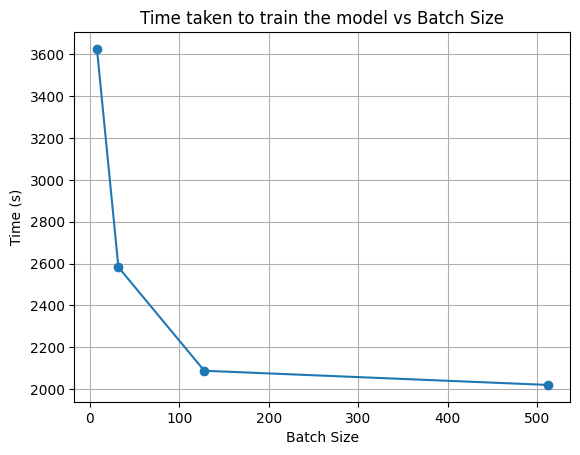

In [10]:
# Plot time taken to train the model vs batch size
plt.plot(batch_sizes, train_timer, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Time (s)')
plt.title('Time taken to train the model vs Batch Size')
plt.grid()
plt.show()

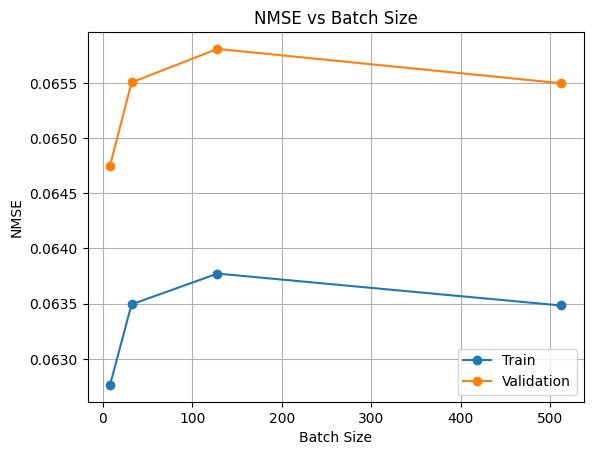

In [11]:
# Plot NMSE of the last epoch vs batch size
plt.plot(batch_sizes, nmse_train_results[:, -1], marker='o', label='Train')
plt.plot(batch_sizes, nmse_val_results[:, -1], marker='o', label='Validation')
plt.xlabel('Batch Size')
plt.ylabel('NMSE')
plt.title('NMSE vs Batch Size')
plt.legend()
plt.grid()
plt.show()

### 2. Number of factors vs NMSE

In [9]:
# Initialize variables
num_factors = [1, 2, 4, 8, 16, 32]
nmse_train_results = np.zeros((len(num_factors), 5))
nmse_val_results = np.zeros((len(num_factors), 5))
train_timer = np.zeros((len(num_factors)))

for i, num_factor in enumerate(num_factors):

    # Create the model
    model = DictionaryFilter(NUM_MOVIES, num_factor, INIT_SCALE, TRAIN_LAMBDA)
    nmse_train = NMSE()
    nmse_val = NMSE()

    # Create the dataset
    dataset = create_train_dataset()
        
    start_time = time.time()  # Start the timer

    # Train the model
    for epoch in range(5):
        progress_bar = tqdm(total=NUM_USERS // BATCH_SIZE, desc=f"Epoch {epoch+1}", unit="batch")
        
        for train_batch, val_batch in dataset:
            x = model(train_batch)
            nmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            nmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
            progress_bar.update(1)
        
        progress_bar.close()

        print("Train NMSE:", nmse_train.result().numpy())
        print("Val NMSE:", nmse_val.result().numpy())
        nmse_train_results[i, epoch] = nmse_train.result().numpy()
        nmse_val_results[i, epoch] = nmse_val.result().numpy()

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    train_timer[i] = elapsed_time  # Store the elapsed time

Epoch 1: 100%|██████████| 3751/3751 [06:46<00:00,  9.24batch/s]


Train NMSE: 0.06491671
Val NMSE: 0.06589751


Epoch 2: 100%|██████████| 3751/3751 [06:46<00:00,  9.23batch/s]


Train NMSE: 0.06472089
Val NMSE: 0.065699555


Epoch 3: 100%|██████████| 3751/3751 [06:42<00:00,  9.31batch/s]


Train NMSE: 0.06461506
Val NMSE: 0.065592706


Epoch 4: 100%|██████████| 3751/3751 [06:41<00:00,  9.34batch/s]


Train NMSE: 0.06454362
Val NMSE: 0.06552058


Epoch 5: 100%|██████████| 3751/3751 [06:42<00:00,  9.32batch/s]


Train NMSE: 0.064489946
Val NMSE: 0.065466404


Epoch 1: 100%|██████████| 3751/3751 [06:53<00:00,  9.06batch/s]


Train NMSE: 0.06394732
Val NMSE: 0.06597164


Epoch 2: 100%|██████████| 3751/3751 [06:53<00:00,  9.08batch/s]


Train NMSE: 0.06373166
Val NMSE: 0.06574561


Epoch 3: 100%|██████████| 3751/3751 [06:54<00:00,  9.05batch/s]


Train NMSE: 0.06361384
Val NMSE: 0.06562425


Epoch 4: 100%|██████████| 3751/3751 [06:55<00:00,  9.03batch/s]


Train NMSE: 0.06353379
Val NMSE: 0.06554346


Epoch 5: 100%|██████████| 3751/3751 [06:55<00:00,  9.04batch/s]


Train NMSE: 0.06347329
Val NMSE: 0.065481886


Epoch 1: 100%|██████████| 3751/3751 [09:45<00:00,  6.41batch/s]


Train NMSE: 0.06239084
Val NMSE: 0.06649409


Epoch 2: 100%|██████████| 3751/3751 [09:52<00:00,  6.33batch/s]


Train NMSE: 0.062138017
Val NMSE: 0.06623272


Epoch 3: 100%|██████████| 3751/3751 [09:47<00:00,  6.38batch/s]


Train NMSE: 0.062000893
Val NMSE: 0.06609196


Epoch 4: 100%|██████████| 3751/3751 [09:53<00:00,  6.32batch/s]


Train NMSE: 0.061906945
Val NMSE: 0.06599514


Epoch 5: 100%|██████████| 3751/3751 [10:03<00:00,  6.22batch/s]


Train NMSE: 0.061836388
Val NMSE: 0.06592133


Epoch 1: 100%|██████████| 3751/3751 [14:14<00:00,  4.39batch/s]


Train NMSE: 0.060045518
Val NMSE: 0.06741056


Epoch 2: 100%|██████████| 3751/3751 [14:04<00:00,  4.44batch/s]


Train NMSE: 0.059828974
Val NMSE: 0.067154825


Epoch 3: 100%|██████████| 3751/3751 [14:15<00:00,  4.39batch/s]


Train NMSE: 0.059714247
Val NMSE: 0.067011945


Epoch 4: 100%|██████████| 3751/3751 [14:09<00:00,  4.42batch/s]


Train NMSE: 0.05963584
Val NMSE: 0.0669162


Epoch 5: 100%|██████████| 3751/3751 [14:04<00:00,  4.44batch/s]


Train NMSE: 0.05957682
Val NMSE: 0.066842616


Epoch 1: 100%|██████████| 3751/3751 [21:25<00:00,  2.92batch/s]


Train NMSE: 0.058750905
Val NMSE: 0.062891945


Epoch 2: 100%|██████████| 3751/3751 [21:17<00:00,  2.94batch/s]


Train NMSE: 0.058518704
Val NMSE: 0.062576845


Epoch 3: 100%|██████████| 3751/3751 [21:10<00:00,  2.95batch/s]


Train NMSE: 0.05839846
Val NMSE: 0.06241463


Epoch 4: 100%|██████████| 3751/3751 [21:19<00:00,  2.93batch/s]


Train NMSE: 0.058317937
Val NMSE: 0.062307198


Epoch 5: 100%|██████████| 3751/3751 [22:26<00:00,  2.78batch/s]


Train NMSE: 0.058257908
Val NMSE: 0.06222919


Epoch 1: 100%|██████████| 3751/3751 [37:39<00:00,  1.66batch/s]


Train NMSE: 0.065363914
Val NMSE: 0.06664718


Epoch 2: 100%|██████████| 3751/3751 [37:05<00:00,  1.69batch/s]


Train NMSE: 0.06505397
Val NMSE: 0.06634139


Epoch 3: 100%|██████████| 3751/3751 [36:56<00:00,  1.69batch/s]


Train NMSE: 0.06489203
Val NMSE: 0.066180855


Epoch 4: 100%|██████████| 3751/3751 [37:01<00:00,  1.69batch/s]


Train NMSE: 0.064784676
Val NMSE: 0.06607418


Epoch 5: 100%|██████████| 3751/3751 [36:50<00:00,  1.70batch/s]

Train NMSE: 0.06470522
Val NMSE: 0.06599545


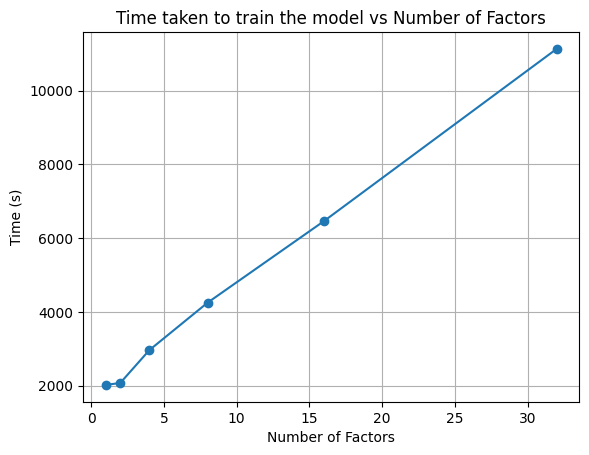

In [10]:
# Plot time taken to train the model vs number of factors
plt.plot(num_factors, train_timer, marker='o')
plt.xlabel('Number of Factors')
plt.ylabel('Time (s)')
plt.title('Time taken to train the model vs Number of Factors')
plt.grid()
plt.show()

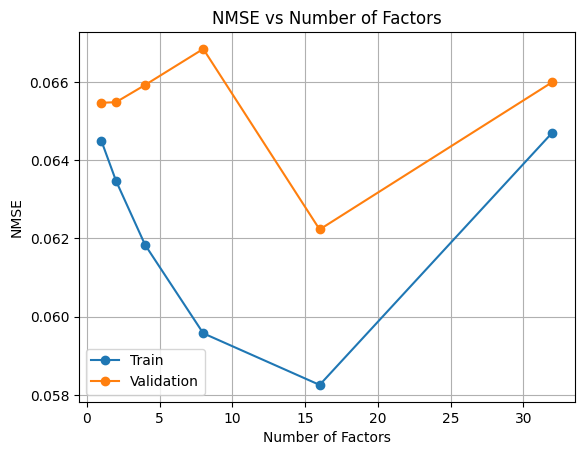

In [11]:
# Plot NMSE of the last epoch vs number of factors
plt.plot(num_factors, nmse_train_results[:, -1], marker='o', label='Train')
plt.plot(num_factors, nmse_val_results[:, -1], marker='o', label='Validation')
plt.xlabel('Number of Factors')
plt.ylabel('NMSE')
plt.title('NMSE vs Number of Factors')
plt.legend()
plt.grid()
plt.show()

### 3. Number of epochs vs NMSE

In [9]:
# Initialize variables
nmse_train_results = np.zeros(NUM_EPOCHS)
nmse_val_results = np.zeros(NUM_EPOCHS)
nmse_test_results = np.zeros(NUM_EPOCHS)

# Create the model
model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
nmse_train = NMSE()
nmse_val = NMSE()
nmse_test = NMSE()

# Create the dataset
dataset = create_full_dataset()

# Train the model
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(total=NUM_USERS // BATCH_SIZE, desc=f"Epoch {epoch+1}", unit="batch")
    
    for train_batch, val_batch, test_batch in dataset:
        x = model(train_batch)
        nmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
        nmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
        nmse_test.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))
        progress_bar.update(1)
    
    progress_bar.close()

    print("Train NMSE:", nmse_train.result().numpy())
    print("Val NMSE:", nmse_val.result().numpy())
    print("Test NMSE:", nmse_test.result().numpy())
    nmse_train_results[epoch] = nmse_train.result().numpy()
    nmse_val_results[epoch] = nmse_val.result().numpy()
    nmse_test_results[epoch] = nmse_test.result().numpy()

Epoch 1: 100%|██████████| 3751/3751 [21:55<00:00,  2.85batch/s]


Train NMSE: 0.0564969
Val NMSE: 0.060463846
Test NMSE: 0.060406983


Epoch 2: 100%|██████████| 3751/3751 [21:50<00:00,  2.86batch/s]


Train NMSE: 0.056312904
Val NMSE: 0.060230587
Test NMSE: 0.060172968


Epoch 3: 100%|██████████| 3751/3751 [21:51<00:00,  2.86batch/s]


Train NMSE: 0.056222983
Val NMSE: 0.060118582
Test NMSE: 0.060059253


Epoch 4: 100%|██████████| 3751/3751 [21:54<00:00,  2.85batch/s]


Train NMSE: 0.05616411
Val NMSE: 0.060046036
Test NMSE: 0.059985973


Epoch 5: 100%|██████████| 3751/3751 [21:49<00:00,  2.86batch/s]


Train NMSE: 0.05612126
Val NMSE: 0.059993953
Test NMSE: 0.05993284


Epoch 6: 100%|██████████| 3751/3751 [21:55<00:00,  2.85batch/s]


Train NMSE: 0.056087904
Val NMSE: 0.05995099
Test NMSE: 0.05989165


Epoch 7: 100%|██████████| 3751/3751 [21:45<00:00,  2.87batch/s]


Train NMSE: 0.05606035
Val NMSE: 0.059917476
Test NMSE: 0.059857976


Epoch 8: 100%|██████████| 3751/3751 [21:52<00:00,  2.86batch/s]


Train NMSE: 0.056037
Val NMSE: 0.059889168
Test NMSE: 0.059828866


Epoch 9: 100%|██████████| 3751/3751 [21:45<00:00,  2.87batch/s]


Train NMSE: 0.056016877
Val NMSE: 0.059864458
Test NMSE: 0.059804235


Epoch 10: 100%|██████████| 3751/3751 [21:45<00:00,  2.87batch/s]


Train NMSE: 0.055999372
Val NMSE: 0.059842683
Test NMSE: 0.059782695


Epoch 11: 100%|██████████| 3751/3751 [21:51<00:00,  2.86batch/s]


Train NMSE: 0.055983715
Val NMSE: 0.059823204
Test NMSE: 0.059763696


Epoch 12: 100%|██████████| 3751/3751 [21:45<00:00,  2.87batch/s]


Train NMSE: 0.055969805
Val NMSE: 0.059805922
Test NMSE: 0.059746776


Epoch 13: 100%|██████████| 3751/3751 [21:52<00:00,  2.86batch/s]


Train NMSE: 0.055957038
Val NMSE: 0.05979018
Test NMSE: 0.059730604


Epoch 14: 100%|██████████| 3751/3751 [21:51<00:00,  2.86batch/s]


Train NMSE: 0.05594526
Val NMSE: 0.059775904
Test NMSE: 0.05971628


Epoch 15: 100%|██████████| 3751/3751 [21:45<00:00,  2.87batch/s]


Train NMSE: 0.05593427
Val NMSE: 0.05976275
Test NMSE: 0.059703324


Epoch 16: 100%|██████████| 3751/3751 [21:49<00:00,  2.86batch/s]


Train NMSE: 0.05592412
Val NMSE: 0.059751052
Test NMSE: 0.05969121


Epoch 17: 100%|██████████| 3751/3751 [21:47<00:00,  2.87batch/s]


Train NMSE: 0.055914573
Val NMSE: 0.05973984
Test NMSE: 0.059679825


Epoch 18: 100%|██████████| 3751/3751 [21:57<00:00,  2.85batch/s]


Train NMSE: 0.055905804
Val NMSE: 0.059729148
Test NMSE: 0.059669122


Epoch 19: 100%|██████████| 3751/3751 [21:46<00:00,  2.87batch/s]


Train NMSE: 0.055897508
Val NMSE: 0.05971901
Test NMSE: 0.0596594


Epoch 20: 100%|██████████| 3751/3751 [21:52<00:00,  2.86batch/s]

Train NMSE: 0.055889625
Val NMSE: 0.059709687
Test NMSE: 0.059650145


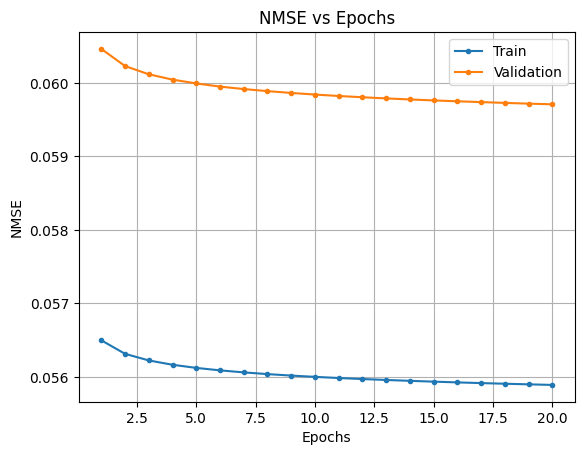

In [10]:
# Plot NMSE vs number of epochs
plt.plot(np.arange(1, NUM_EPOCHS+1), nmse_train_results, marker='.', label='Train')
plt.plot(np.arange(1, NUM_EPOCHS+1), nmse_val_results, marker='.', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('NMSE')
plt.title('NMSE vs Epochs')
plt.legend()
plt.grid()
plt.show()

In [11]:
# Save results to a CSV file
results = pd.DataFrame({
    'Train Results': nmse_train_results,
    'Validation Results': nmse_val_results,
    'Test Results': nmse_test_results
})
results.to_csv('Results/Netflix/num_epochs.csv', index=False)